In [1]:
import sys
import gc
import os
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")
sys.path.append("/Users/ueki/Desktop/JP_EN_Transalation")

In [2]:
from models.Seq2Seq_1_batch import Seq2Seq
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.build_emb import build_en_emb,build_jp_emb
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import torch

Using TensorFlow backend.


In [3]:
config={
    "corpus_file":"../data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "SOS_token":1,
    "EOS_token":0,
    "UNK_token":2,
    "max_features":5000,
    "MAX_LENGTH":20,
    "train_size":15000,
    "val_size":100,
    "batch_size":1024,
    "epochs":1,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":300,
    "input_dim":5000,
    "output_dim":5000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.1,
    "trained_param_dir":"../trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":25,
    "en_W2V_FILE" : "../data/GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":"../data/ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.01,
}

# train

In [4]:
data=loadLangs(config)

reading lines


In [5]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [6]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

W0803 14:15:32.090662 4535977408 toolwrapper.py:77] stdbuf was not found; communication with perl may hang due to stdio buffering.


In [7]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [8]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [9]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [10]:
input_en = data[src_col]

In [11]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x,target=True))

In [12]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [13]:
trainer = Seq2Seq(config)

epoch1 start
loss_av in eopch0=> 66.80566101074218
time-> 120.9071900844574


<Figure size 432x288 with 0 Axes>

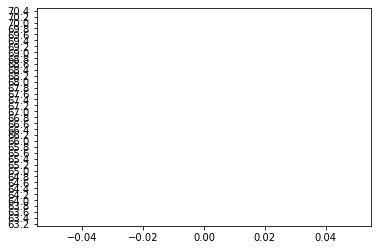

In [14]:
trainer.trainIters(input_source_padded,input_target_padded)

# test

In [14]:
val_data_id = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))

In [15]:
ret=[]
for s in val_data_id:
    ret.append(trainer.translate(s))

In [16]:
for src,pred,target in zip(val_data[src_col],ret,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> theres no need to hurry.

pred-> 人達 コメディアン 着る 予備 とっても 愛さ 爆弾 怒っ たかっ せっせと 代 せっせと 驚き 習慣 何一つ もともと 昼 傘 抗議 脱が 脱が 脱が 脱が そして 丸
ans-> 急ぐ 必要 は あり ませ ん 。
------------------
src-> i want to join your band.

pred-> 人達 コメディアン 着る 予備 とっても 愛さ 爆弾 怒っ たかっ せっせと 代 せっせと 驚き 習慣 何一つ もともと 昼 傘 抗議 脱が 脱が 脱が 脱が そして 丸
ans-> あなた の バンド に 入り たい な 。
------------------
src-> you must keep an eye on the child.

pred-> 人達 着る コメディアン 予備 とっても 出来る 昼 傘 抗議 脱が 脱が 脱が 脱が 脱が そして 丸 翻訳 酒飲み 脱が 脱が 脱が そして 丸 翻訳 酒飲み
ans-> その 子 から 目 を 離さ ない よう に し なけれ ば いけ ない 。
------------------
src-> he is mad about music.

pred-> 人達 コメディアン 九州 着る コメディアン 予備 予備 とっても 出来る 昼 何一つ もともと 昼 傘 抗議 脱が 脱が 脱が 脱が そして 丸 翻訳 酒飲み 脱が 脱が
ans-> 彼 は 音楽 狂 だ 。
------------------
src-> with a little more patience she would have succeeded.

pred-> 人達 コメディアン 着る 予備 とっても 愛さ 爆弾 怒っ たかっ せっせと 代 せっせと 驚き 習慣 何一つ もともと 昼 傘 抗議 脱が 脱が 脱が 脱が そして 丸
ans-> もし 彼女 が もう少し 我慢強かっ たら 、 成功 し て い た だろ う に 。
------------------
src-> they painted the fence green.

pred-> アメリカンフットボール 脱が 脱が 脱が 脱が 脱が 脱が 脱が 脱が